MIT License

Copyright (c) 2024 Mohannad Shehadeh

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
using SpecialFunctions
using Plots
using DelimitedFiles
using Statistics

In [2]:
# plotly()

In [3]:
Q(x) = 1/2*erfc(x/sqrt(2));
Φ(x) = 1-Q(x);
gauss_prob(μ,σ,interval_start,interval_end) = Φ((interval_end-μ)/σ) - Φ((interval_start-μ)/σ);
gauss_cdf(μ,σ,x) = Φ((x-μ)/σ);
gauss_compl_cdf(μ,σ,x) = Q((x-μ)/σ);

In [4]:
# (n,k,M) = (14,4,140)
M = 140;
k = 4
μs = [
 0.16324 
 0.46320 
 0.75788 
 0.92457 
];
σs = [
 0.11901 
 0.16844 
 0.12753 
 0.06539  
];
μs = M*μs;
σs = M*σs;
@assert k == length(μs)
@assert k == length(σs)

In [5]:
# # (n,k,M) = (3,3,19)
# M = 19
# k = 3
# μs = [
#  0.28188 
#  0.53462 
#  0.80658 
# ];
# σs = [
#  0.20579 
#  0.21949 
#  0.17529 
# ];
# μs = M*μs;
# σs = M*σs;
# @assert k == length(μs)
# @assert k == length(σs)

In [6]:
# # (n,k,M) = (4,5,64)
# M = 64
# k = 5
# μs = [
#  0.13354 
#  0.32685 
#  0.58717 
#  0.79223 
#  0.93449 
# ];
# σs = [
#  0.10412 
#  0.15368 
#  0.15941 
#  0.12445 
#  0.06689 
# ];
# μs = M*μs;
# σs = M*σs;
# @assert k == length(μs)
# @assert k == length(σs)

In [7]:
# LFSR parameters
SKIM = 8;
SIZE = 64;

SEED_LIST_SIZE = 100;

tap_list = parse.(UInt64, "0x" .* readdlm("prim-poly-db/$SIZE.txt", String));
# tap_list_string = readdlm("prim-poly-db/$SIZE.txt", String);
# SEED = 0x01;
# SEED_STRING = "$SIZE'h"*string(SEED, base=16)
# feedback_choice = 51 
# FEEDBACK = tap_list[feedback_choice];
println("SIZE = $SIZE")
# FEEDBACK_STRING = "$SIZE'h"*tap_list_string[feedback_choice];
# println("FEEDBACK = " * FEEDBACK_STRING)
# println("SEED = $SEED (" * SEED_STRING * ")")
println("SKIM = $SKIM")

println("SEED_LIST_SIZE = $SEED_LIST_SIZE")


PERIOD = (2.0^SIZE-1)
println("Period in days at 300 MHz: $(PERIOD / (300e6) / (24*3600))")

SIZE = 64
SKIM = 8
SEED_LIST_SIZE = 100
Period in days at 300 MHz: 711679.9411153377


In [8]:
seeds = [rand(UInt64) & ((UInt64(1)<<SIZE) - 1) for i in 1:(SKIM*SEED_LIST_SIZE)];

In [9]:
states = zeros(UInt64,SKIM);
states = copy(seeds[end-SKIM+1:end]);
taps = tap_list[end-SKIM+1:end];
function lfsr()
    global state
    result = UInt64(0)
    for i in 1:SKIM
        if ((states[i] & 1) != 0)
            states[i] = (states[i] >> 1) ⊻ taps[i]
        else 
            states[i] = (states[i] >> 1)
        end
        if (states[i]&0x1 == 0x1)
            result ⊻= UInt64(1) << (i-1)
        end
    end
    return result
end;

In [10]:
# mean([lfsr()*1.0 for sample in 1:10000])

In [11]:
# plot([lfsr()/(2^SKIM-1) for call in 1:100])
# plot!([rand() for call in 1:100])

All values $x\in [i-0.5,i+0.5)$ round to $i$
$$
p_1 = \int_{-\infty}^{1+0.5} f_X(x)dx
$$
$$
p_i = \int_{i-0.5}^{i+0.5} f_X(x)dx \quad i \in \{2,3,\dots,M-1\}
$$
$$
p_M = \int_{M-0.5}^{\infty} f_X(x)dx
$$

In [12]:
function bin_probs(μ,σ)
    p = zeros(M);
    p[1] = gauss_cdf(μ,σ,1+0.5)
    for i in 2:M-1
        p[i] = gauss_prob(μ,σ,i-0.5,i+0.5)
    end
    p[M] = gauss_compl_cdf(μ,σ,M-0.5)
    return p
end;

In [13]:
ps = [bin_probs(μs[i],σs[i]) for i in 1:k];

In [14]:
# ps = [[ps[i][j] < 2*1.0/(2.0^SKIM-1.0) ? 2*1.0/(2.0^SKIM-1.0) : ps[i][j] for j in 1:M] for i in 1:k];
# ps = [ps[i] ./ sum(ps[i]) for i in 1:k];

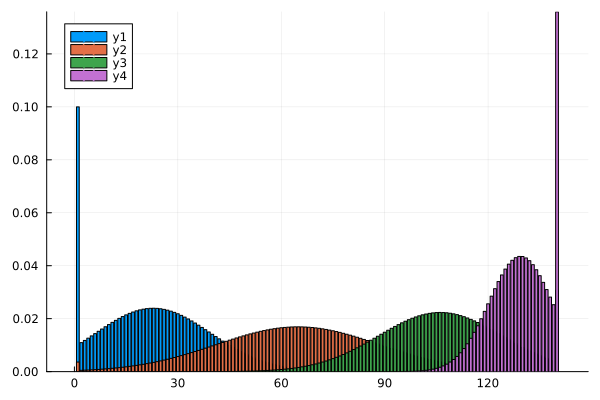

In [15]:
bar(1:M,ps,marker=:x)

In [16]:
bin_boundaries = [round.(UInt64,cumsum(ps[i])*(2.0^SKIM-1.0)) for i in 1:k];

In [17]:
prod([bin_boundaries[i][end] == UInt64(2)^SKIM-UInt64(1) for i in 1:k]) == 1

true

In [18]:
cumsump_hat = bin_boundaries ./ (2.0^SKIM-1.0);

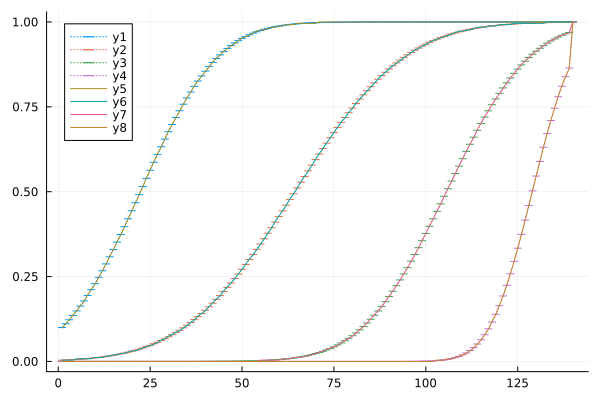

In [19]:
plot(cumsum.(ps),linestyle=:dot,marker=:hline,legendt=:left)
plot!(cumsump_hat)

In [20]:
function get_sample(j)
    x = lfsr()
    s = M;
    for i in M-1:-1:1
        if (x < bin_boundaries[j][i])
            s = i
        end
    end
    return s
end;

In [21]:
num_samples = 200*200
samples = [[get_sample(j) for i in 1:num_samples] for j in 1:k];

In [22]:
relfreqs = [[sum(samples[j] .== i ) for i in 1:M] ./ length(samples[j]) for j in 1:k];

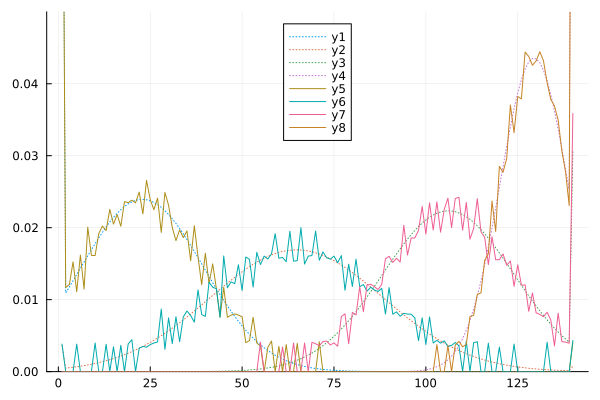

In [23]:
plot(ps,linestyle=:dot,legend=:top)
plot!(relfreqs)
ylims!(0,0.05)

In [24]:
parameter_file_string = 
"// MIT License
//
// Copyright (c) 2024 Mohannad Shehadeh
//
// Permission is hereby granted, free of charge, to any person obtaining a copy
// of this software and associated documentation files (the \"Software\"), to deal
// in the Software without restriction, including without limitation the rights
// to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
// copies of the Software, and to permit persons to whom the Software is
// furnished to do so, subject to the following conditions:
//
// The above copyright notice and this permission notice shall be included in all
// copies or substantial portions of the Software.
//
// THE SOFTWARE IS PROVIDED \"AS IS\", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
// IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
// FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
// AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
// LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
// OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
// SOFTWARE.

"
parameter_file_string *= "parameter M = $M; // max mark \n"
parameter_file_string *= "parameter k = $k; // num marks per block\n"
parameter_file_string *= "parameter SKIM = $SKIM; // uniform prng source width \n"
parameter_file_string *= "parameter SIZE = $SIZE; // lfsr size \n"
parameter_file_string *= "parameter SEED_LIST_SIZE = $SEED_LIST_SIZE; \n"
parameter_file_string *= "parameter [SEED_LIST_SIZE*SKIM*SIZE-1:0] SEEDS =\n{"
parameter_file_string *= rstrip(prod(prod.(["$SIZE'h" .* string.(seeds,base=16) .* ",\n"])), [',','\n']) * 
"};\n"
parameter_file_string *= "// lfsr prim polys \n"
parameter_file_string *= "parameter [SKIM*SIZE - 1 : 0] PRIMPOLYS =\n{" *
rstrip(prod(prod.(["$SIZE'h" .* string.(taps,base=16) .* ",\n"])), [',','\n']) * 
"};\n"
parameter_file_string *= "// boundaries of bins to produce k different non-uniform distributions \n"
parameter_file_string *= "parameter [SKIM*M*k - 1 : 0] BINBOUND =\n{" *
rstrip(prod(prod.(["$SKIM'h" .* string.(bin_boundaries[j],base=16) .* ",\n" for j in 1:k])), [',','\n']) * 
"};"

"// MIT License\n//\n// Copyright (c) 2024 Mohannad Shehadeh\n//\n// Permission is hereby granted, free of charge, to any person obtaining a copy\n// of this software and associated documentation files (the \"Software\"), to deal\n// in the Software without restriction, includin" ⋯ 22451 bytes ⋯ "0,\n8'h0,\n8'h0,\n8'h1,\n8'h1,\n8'h1,\n8'h2,\n8'h2,\n8'h3,\n8'h4,\n8'h5,\n8'h6,\n8'h8,\n8'ha,\n8'hd,\n8'h10,\n8'h14,\n8'h18,\n8'h1e,\n8'h23,\n8'h2a,\n8'h31,\n8'h39,\n8'h42,\n8'h4b,\n8'h55,\n8'h5f,\n8'h6a,\n8'h75,\n8'h80,\n8'h8b,\n8'h96,\n8'ha1,\n8'hab,\n8'hb5,\n8'hbe,\n8'hc7,\n8'hcf,\n8'hd6,\n8'hdc,\n8'hff};"

In [25]:
write("multiDiscNonUnifHQ_paramfile.v", parameter_file_string);

In [26]:
# ;cat multiDiscNonUnifHQ_paramfile.v

In [27]:
# samples_flat = samples[1];
# for i in 2:k
#     samples_flat = [samples_flat; samples[i]]
# end
# samples_flat'
# m_data = readdlm("m_data.txt", Int64);
# sum(m_data .== samples_flat) == length(m_data)